# **Sentiment Analysis of Google Play Store Reviews Using BiLSTM and fastText Word Embedding**
Model *deep learning* yang dibangun menggunakan *PyTorch* dan *TorchText* untuk mengklasifikasikan sentimen ulasan aplikasi menggunakan data yang diambil dari *Google Play Store*.

(Kode ini untuk skripsi)

1. [Pengumpulan Data](#1-pengumpulan-data)
2. [Preprocessing Data](#2-preprocessing-data)
    - Text Cleaning
    - Case Folding
    - Tokenization
    - Stopword Removal
    - Stemming
3. [Pelabelan Data](#3-pelabelan-data)
4. [Pembagian Data](#4-pembagian-data)
5. [Ekstraksi Fitur fastText](#5-ekstraksi-fitur-fasttext)
6. [Pembentukan dan Pelatihan Model BiLSTM](#6-pembentukan-dan-pelatihan-model-bilstm)
7. [Klasifikasi Sentimen](#7-klasifikasi-sentimen)
8. [Evaluasi Model](#8-evaluasi-model)

<a id='section1'></a>
# **1. Pengumpulan Data**
Pada tahap pengumpulan data, penelitian ini melakukan scraping data ulasan pada Google Play Store terhadap aplikasi Maxim dengan menggunakan package google-play-scraper. Data yang diambil berjumlah 10.000 ulasan berbahasa Indonesia terbaru pada aplikasi Maxim.

Dalam ulasan aplikasi, sentimen positif sering kali lebih dominan daripada negatif. Jika kita mengambil data secara acak, kemungkinan besar kita mendapatkan bias ke kelas positif, yang dapat menyebabkan model menjadi terlalu condong ke sentimen positif. Mengambil jumlah yang sama untuk ulasan positif dan negatif (rating 1-2 untuk negatif, 4-5 untuk positif) membantu menghindari bias ini, sehingga model dapat belajar secara merata dari kedua sentimen, tanpa adanya ketidakseimbangan yang terlalu ekstrim diantara kedua kelas data.

In [ ]:
# Package yang diperlukan untuk analisis sentimen
from google_play_scraper import app, Sort, reviews 
import os                               
import json                                         
import csv                                          
import pandas as pd                                 
import numpy as np
import re
import time
import spacy
import random
from pathlib import Path
from datetime import datetime
from collections import Counter
from pprint import pprint
from itertools import product

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import torchtext.legacy
from torchtext.legacy import data 
from torchtext.vocab import Vectors

import fasttext
import fasttext.util
import gensim
import compress_fasttext

import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import ast
from googletrans import Translator
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
# Mengubah working directory
os.chdir('D:\Dokumen\Skripsi\Referensi\Kode\SA_BiLSTM+fastText')

In [ ]:
# Kode scraping data ulasan aplikasi Maxim
# Fungsi untuk memberikan label berdasarkan rating ulasan
def label_sentiment(rating):
    if rating in [1, 2]:
        return 'negatif'
    elif rating in [4, 5]:
        return 'positif'
    return None  

# Variabel untuk menyimpan ulasan berlabel positif dan negatif
low_rating = []     
high_rating = []   
target_count = 2500

# Proses scraping ulasan
while len(low_rating) < target_count or len(high_rating) < target_count:
    reviews_data, continuation_token = reviews(
        'com.taxsee.taxsee',    
        lang='id',   
        country='id',
        sort=Sort.NEWEST,    
        count=100000            
    )

    # Proses setiap ulasan
    for review in reviews_data:
        if len(low_rating) >= target_count and len(high_rating) >= target_count:
            break

        rating = review.get('score')
        sentiment = label_sentiment(rating)

        if sentiment == 'negatif' and len(low_rating) < target_count:
            low_rating.append(review)
        elif sentiment == 'positif' and len(high_rating) < target_count:
            high_rating.append(review)

    if len(low_rating) >= target_count and len(high_rating) >= target_count:
        break

    if continuation_token is None:
        break

# Gabungkan ulasan dengan rating rendah dan tinggi
combined_reviews = low_rating + high_rating

# Simpan hasil scraping ke dalam file CSV
with open('combined_reviews.csv', 'w', encoding='utf8', newline='') as output_file:
    fieldnames = ['content', 'score'] 
    writer = csv.DictWriter(output_file, fieldnames=fieldnames)
    writer.writeheader()
    for review in combined_reviews:
        writer.writerow({
            'content': review.get('content', ''),  
            'score': review.get('score', '')      
        })

print("Data ulasan berhasil disimpan ke 'combined_reviews.csv'")

In [ ]:
# Kode scraping data ulasan aplikasi Maxim (versi padat)
def label_sentiment(rating):
    return 'negatif' if rating in [1, 2] else 'positif' if rating in [4, 5] else None

# Target jumlah ulasan untuk masing-masing kategori
target_count = 5000
low_rating, high_rating = [], []

# Proses scraping ulasan
while len(low_rating) < target_count or len(high_rating) < target_count:
    reviews_data, continuation_token = reviews(
        'com.taxsee.taxsee', lang='id', country='id', sort=Sort.NEWEST, count=100000
    )
    for review in reviews_data:
        sentiment = label_sentiment(review.get('score'))
        if sentiment == 'negatif' and len(low_rating) < target_count:
            low_rating.append(review)
        elif sentiment == 'positif' and len(high_rating) < target_count:
            high_rating.append(review)
        if len(low_rating) >= target_count and len(high_rating) >= target_count:
            break
    if continuation_token is None:
        break

# Gabungkan ulasan dengan rating rendah dan tinggi    
combined_reviews = low_rating + high_rating

# Simpan hasil scraping ke dalam file CSV
with open('combined_reviews.csv', 'w', encoding='utf8', newline='') as output_file:
    fieldnames = ['content', 'score']  
    writer = csv.DictWriter(output_file, fieldnames=fieldnames)
    writer.writeheader()
    for review in combined_reviews:
        writer.writerow({
            'content': review.get('content', ''),  
            'score': review.get('score', '')      
        })

In [6]:
# Membaca file .csv hasil scraping ulasan
df = pd.read_csv("combined_reviews.csv", engine="python", header=None)
df.head(5)

,0,1
0,content,score
1,maksa,1
2,tolong perbaiki mapsnya.maps ojol ko.kaya maps...,1
3,"ongkosnya kecil,. kasiann drivernya.. GK ada o...",1
4,"Maps eror kalau ketujuan, supirnya gk ada saba...",1


In [8]:
# Hapus kolom yang tidak diperlukan, yang diambil hanya "content"
columns_to_drop = [1]
df = df.drop(columns=columns_to_drop)

# Hapus baris pertama
df = df.rename(columns=df.iloc[0]).drop(df.index[0])

# Simpan dataframe yang telah diubah ke dalam file .csv
df.to_csv('review_content.csv', index=False)

# Memanggil data
df.head(5)

,content
1,maksa
2,tolong perbaiki mapsnya.maps ojol ko.kaya maps...
3,"ongkosnya kecil,. kasiann drivernya.. GK ada o..."
4,"Maps eror kalau ketujuan, supirnya gk ada saba..."
5,baik


<a id='section2'></a>
# **2. Preprocessing Data**
Pra-proses teks atau *text preprocessing adalah* serangkaian proses yang digunakan untuk menyiapkan teks mentah agar lebih siap untuk dianalisis. Tujuan utama *text preprocessing* adalah mengurangi kebisingan dan menyederhanakan teks sehingga analisis lanjutan atau algoritma pembelajaran mesin dapat bekerja lebih efisien dan efektif. Pada tahapan *text preprocessing* semua dilakukan dengan menggunakan *library* dari *Natural Language Toolkit* (NLTK), untuk memudahkan proses *text preprocessing*.

In [9]:
# Memanggil model spaCy untuk tokenisasi
nlp = spacy.blank("id")

Dua sel dibawah hanya berfungsi untuk mengecek dan menangani kasus baris dengan nilai NaN, yang dapat menyebabkan kode pemrosesan teks tidak mampu membaca baris tersebut, karena tidak memiliki datatype str.

In [10]:
# Menampilkan baris untuk mengecek yang memiliki nilai NaN pada kolom 'content'
print(df[df['content'].isna()])

Empty DataFrame
Columns: [content]
Index: []


In [11]:
# Menghapus baris dengan nilai NaN pada kolom 'content'
df = df.dropna(subset=['content'])

# Periksa kembali apakah masih ada nilai NaN
print(df['content'].isna().sum())  # Output harus 0

0


Dibawah didefinisikan kode untuk tahap-tahap text preprocessing. Adapun tahap-tahap yang dilakukan adalah:
- **Text Cleaning**: proses menghapus tanda baca dan karakter yang tidak diperlukan seperti URL, angka, karakter spesial (seperti emoji), tanda baca, dan spasi berlebih.
- **Case Folding**: proses dimana seluruh huruf dalam teks ulasan disesuaikan menjadi huruf kecil atau huruf besar, sehingga seluruh huruf dalam teks memiliki format penulisan yang seragam.
- **Tokenization**: proses membagi teks atau dokumen menjadi unit‑unit yang lebih kecil yang disebut ”token”. Token merujuk pada kata‑kata individual dalam teks.
- **Stopword Removal**: proses mengidentifikasi dan menghapus kata‑kata umum yang tidak memberikan informasi signifikan dalam analisis sentimen.
- **Stemming**: proses yang melibatkan penghilangan akhiran atau awalan kata‑kata untuk menghasilkan bentuk dasar atau ”akar” kata. 

In [ ]:
# Kode per langkah preprocessing
# Step 1: Cleansing text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Hapus URL
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip() 
    return text

# Step 2: Case folding
def case_folding(text):
    return text.lower()

# Step 3: Tokenisasi
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc] 

# Step 4: Menghapus stopword menggunakan daftar dari Sastrawi
stopword_factory = StopWordRemoverFactory()
stopword_list = set(stopword_factory.get_stop_words())  

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopword_list] 

# Step 5: Stemming menggunakan Sastrawi)
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stemming(tokens):
    return [stemmer.stem(word) for word in tokens]

# Fungsi untuk menyimpan hasil setiap langkah ke CSV
def save_to_csv(df, step_name):
    filename = f'processed_data_{step_name}.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {step_name} result to {filename}")

# Fungsi utama untuk memproses dan menyimpan setiap langkah
def process_and_save_steps(df):
    # Step 1: Cleansing text
    df['cleaned_text'] = df['content'].apply(clean_text)
    save_to_csv(df[['content', 'cleaned_text']], 'cleansing')

    # Step 2: Case folding
    df['case_folding'] = df['cleaned_text'].apply(case_folding)
    save_to_csv(df[['cleaned_text', 'case_folding']], 'case_folding')

    # Step 3: Tokenisasi
    df['tokenized_text'] = df['case_folding'].apply(tokenize)
    save_to_csv(df[['case_folding', 'tokenized_text']], 'tokenization')

    # Step 4: Penghapusan stopword
    df['no_stopwords'] = df['tokenized_text'].apply(remove_stopwords)
    save_to_csv(df[['tokenized_text', 'no_stopwords']], 'stopword_removal')

    # Step 5: Stemming
    df['stemmed_text'] = df['no_stopwords'].apply(stemming)
    save_to_csv(df[['no_stopwords', 'stemmed_text']], 'stemming')

# Menjalankan proses preprocessing
df = pd.read_csv('review_content.csv')
process_and_save_steps(df)

Saved cleansing result to processed_data_cleansing.csv
Saved case_folding result to processed_data_case_folding.csv
Saved tokenization result to processed_data_tokenization.csv
Saved stopword_removal result to processed_data_stopword_removal.csv
Saved stemming result to processed_data_stemming.csv


In [13]:
# Filtering dan penghapusan baris dengan "processed_text" yang kosong (untuk kode per langkah)
# Hapus baris yang kosong setelah preprocessing (cek apakah list kosong)
df_filtered_full = df[df['stemmed_text'].apply(lambda x: len(x) > 0)]

# Tampilkan hasil setelah filtering
print(df_filtered_full)

# Simpan hasil semua tahap text preprocessing ke file CSV
df_filtered_full.to_csv('filtered_data_full.csv', index=False)

# Simpan hanya ulasan awal ('content') dan hasil tokenisasi ke file CSV
columns_to_drop = ['cleaned_text', 'case_folding', 'no_stopwords']
df_filtered = df_filtered_full.drop(columns=columns_to_drop)

# Ganti nama kolom hasil akhir agar sesuai
df_filtered = df_filtered.rename(columns={'stemmed_text': 'processed_text'})

# Simpan dataframe yang telah diubah ke dalam file .csv
df_filtered.to_csv('filtered_data.csv', index=False)

                                                content  \
0                                                 maksa   
1     tolong perbaiki mapsnya.maps ojol ko.kaya maps...   
2     ongkosnya kecil,. kasiann drivernya.. GK ada o...   
3     Maps eror kalau ketujuan, supirnya gk ada saba...   
4                                                  baik   
...                                                 ...   
4995                                     bagus supirnya   
4996                                   driver baik hati   
4997                                             mantap   
4998                                 asikk ramah banget   
4999                   biarlah bintang yang membuktikan   

                                           cleaned_text  \
0                                                 maksa   
1      tolong perbaiki mapsnyamaps ojol kokaya maps gta   
2     ongkosnya kecil kasiann drivernya GK ada otak ...   
3     Maps eror kalau ketujuan supirnya gk ada sabarnya

<a id='section3'></a>
# **3. Pelabelan Data**
Proses pelabelan dilakukan dengan memberi label pada data ulasan, untuk mengetahui apakah suatu ulasan memiliki sentimen positif atau negatif. Pelabelan dilakukan secara otomatis dengan menggunakan metode *lexicon-based*, dengan menggunakan kamus Valence Aware Dictionary for Sentiment Reasoning (VADER).

In [20]:
# Mengunduh leksikon VADER
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...


True

Pertama, akan didefinisikan fungsi untuk menerjemahkan teks dari bahasa Indonesia ke bahasa Inggris, karena VADER menggunakan bahasa Inggris dalam pelabelannya. VADER akan mengembalikan nilai compound berdasarkan kata-kata dalam suatu teks, dan dari nilai ini kita bisa menentukan label untuk data. Untuk negatif, compound < -0.05; dan untuk positif > 0.05, dengan nilai compound di antaranya menandakan sentimen netral, yang tidak dipakai dalam penelitian ini dan akan dihapus.

In [14]:
# Membuat objek Google Translate dan VADER untuk pelabelan data (0.05)
translator = Translator()
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk menerjemahkan teks dari bahasa Indonesia ke bahasa Inggris
def translate_text(text):
    try:
        translated = translator.translate(text, src='id', dest='en')
        return translated.text
    except Exception as e:
        print(f"Error in translation: {e}")
        return text

# Fungsi untuk pelabelan sentimen otomatis menggunakan VADER
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positif'  
    elif scores['compound'] <= -0.05:
        return 'negatif'  
    else:
        return None 

# Menyimpan ulasan yang valid (tidak netral)
filtered_reviews = []

Kode dibawah menerapkan fungsi yang telah didefinisikan pada data ulasan. Kolom content berisi ulasan asli, processed_text berisi ulasan yang sudah diproses, translated_text berisi processed_text yang sudah diterjemahkan ke bahasa Inggris, dan vader_sentiment adalah label berupa sentimen positif atau negatif berdasarkan skor compound VADER, yang tidak ditampilkan pada tahap ini.

In [15]:
# Kode untuk sampel, menguji waktu running
# Misalkan df adalah DataFrame yang sudah ada dengan kolom "processed_text"
df = pd.read_csv('filtered_data.csv')

# Step 2: Ambil hanya n baris data untuk uji cepat
df_sample = df.sample(n=100, random_state=42) 

# Step 3: Menerjemahkan kolom "processed_text" ke bahasa Inggris
df_sample['translated_text'] = df_sample['processed_text'].apply(translate_text)

# Step 4: Pelabelan otomatis menggunakan VADER pada teks yang sudah diterjemahkan
df_sample['vader_sentiment'] = df_sample['translated_text'].apply(vader_sentiment)

# Step 5: Hapus baris dengan nilai None di vader_sentiment
df_sample = df_sample.dropna(subset=['vader_sentiment'])

# Tampilkan hasil setelah pelabelan
print(df_sample[['processed_text', 'translated_text', 'vader_sentiment']])

# Simpan hasil pelabelan ke file CSV baru (untuk data uji coba ini)
df_sample.to_csv('vader_labeled_sample.csv', index=False)

                                         processed_text  \
1371  ['gimna', 'kok', 'ngisi', 'kaspro', 'malah', '...   
199   ['maxim', 'update', 'sm', 'titik', 'lokasi', '...   
2194  ['balikin', 'saldo', 'woyyy', 'baru', 'topup',...   
501   ['kemudi', 'nya', 'kasar', 'bgt', 'katakatanya...   
811   ['aplikasi', 'nya', 'sangat', 'cari', 'untungs...   
2825  ['layan', 'prima', 'orang', 'ramah', 'kendara'...   
1221  ['cross', 'cek', 'driver', 'atas', 'nama', 'no...   

                                        translated_text vader_sentiment  
1371  ['Gimna', 'How' how ',' filling ',' kaspro ','...         negatif  
199   ['maxim', 'update', 'sm', 'point', 'location',...         negatif  
2194  ['return', 'balance', 'woyyy', 'new', 'topup',...         positif  
501   ['steering', '' rough ',' rough ',' bgt ',' bg...         negatif  
811   ['application', '' very ',' very ',' search ',...         positif  
2825  ['service', 'prime', 'person', 'friendly', 've...         positif  
1221  ['c

In [ ]:
# Kode untuk dataset full
# Misalkan df adalah DataFrame yang sudah ada dengan kolom "processed_text"
df = pd.read_csv('filtered_data.csv') 

# Step 1: Menerjemahkan kolom "processed_text" ke bahasa Inggris
df['translated_text'] = df['processed_text'].apply(translate_text)

# Step 2: Pelabelan otomatis menggunakan VADER pada teks yang sudah diterjemahkan
df['vader_sentiment'] = df['translated_text'].apply(vader_sentiment)

# Tampilkan hasil setelah pelabelan
print(df[['processed_text', 'translated_text', 'vader_sentiment']])

# Simpan hasil pelabelan ke file CSV baru
df.to_csv('vader_labeled_data.csv', index=False)
# Waktu running: 89m 19.9s (4868 baris)

Error in translation: The read operation timed out
                                         processed_text  \
0         ['ongkos', 'manusia', 'manusia', 'drivernya']   
1                                              ['baik']   
2                                       ['terimakasih']   
3                        ['aplikasi', 'susah', 'pakai']   
4     ['lah', 'management', 'pihak', 'maxim', 'baik'...   
...                                                 ...   
9704                           ['pelayananya', 'goood']   
9705                                         ['mantap']   
9706                                 ['sangat', 'baik']   
9707                                         ['nyaman']   
9708  ['order', 'penuh', 'roy', 'delmax', 'vin', 'h'...   

                                        translated_text vader_sentiment  
0                  ['cost', 'human', 'human', 'driver']            None  
1                                              ['Good']            None  
2                 

Pada sel ini, dilakukan konversi format pada data di kolom translated_text dari yang sebelumnya menyerupai list menjadi string biasa tanpa koma pemisah.

In [ ]:
# Step 1: Baca file CSV yang sudah ada
df = pd.read_csv('vader_labeled_data.csv')

# Step 2: Bersihkan karakter yang tidak diperlukan
df['converted_text'] = df['translated_text'].str.replace(r"[\[\]',]", '', regex=True)

# Step 3: Lakukan pelabelan sentimen dengan VADER pada kolom 'converted_text'
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk pelabelan sentimen otomatis menggunakan skor compound VADER
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0.05:
        sentiment = 'positif'
    elif scores['compound'] < -0.05:
        sentiment = 'negatif'
    else:
        sentiment = None 
    
    return sentiment, scores['compound']

# Terapkan pelabelan dan simpan skor compound VADER di kolom terpisah
df['vader_sentiment'], df['compound'] = zip(*df['converted_text'].apply(vader_sentiment))

# Step 4: Hapus ulasan netral (dengan sentimen None)
df = df.dropna(subset=['vader_sentiment'])

# Step 5: Simpan hasil pelabelan dan skor compound ke file CSV baru
df[['processed_text', 'translated_text', 'converted_text', 'vader_sentiment', 'compound']].to_csv('vader_labeled_with_compound.csv', index=False)

# Tampilkan beberapa hasil
print(df[['processed_text', 'translated_text', 'vader_sentiment', 'compound']].head())

                                      processed_text  \
0  ['gimna', 'kok', 'ngisi', 'kaspro', 'malah', '...   
1  ['maxim', 'update', 'sm', 'titik', 'lokasi', '...   
2  ['balikin', 'saldo', 'woyyy', 'baru', 'topup',...   
3  ['kemudi', 'nya', 'kasar', 'bgt', 'katakatanya...   
4  ['aplikasi', 'nya', 'sangat', 'cari', 'untungs...   

                                     translated_text vader_sentiment  compound  
0  ['Gimna', 'How' how ',' filling ',' kaspro ','...         negatif   -0.1280  
1  ['maxim', 'update', 'sm', 'point', 'location',...         negatif   -0.2023  
2  ['return', 'balance', 'woyyy', 'new', 'topup',...         positif    0.4019  
3  ['steering', '' rough ',' rough ',' bgt ',' bg...         negatif   -0.5719  
4  ['application', '' very ',' very ',' search ',...         positif    0.7220  


<a id='section4'></a>
# **4. Pembagian Data**
Pada tahap pembagian data, data akan dibagi menjadi data latih, data validasi, dan data uji dengan proporsi 60:20:20, 70:25:5, 80:10:10. Pada data latih akan dilatih model yang akan digunakan, pada data validasi akan dievaluasi performa model selama pelatihan untuk memantau overfitting dan menyesuaikan hyperparameter, dan kemudian model yang telah dilatih akan digunakan pada data uji untuk melakukan analisis sentimen dan mengukur performa akhir model pada data baru.

In [3]:
# Fungsi untuk mengubah sentimen menjadi angka
def sentiment_to_float(label):
    if label == 'positif':
        return 1.0
    elif label == 'negatif':
        return 0.0

# Step 1: Baca CSV dan hanya pilih kolom yang dibutuhkan (processed_text dan vader_sentiment)
df = pd.read_csv("vader_labeled_with_compound.csv", usecols=['processed_text', 'vader_sentiment'])

# Simpan CSV baru yang hanya berisi kolom yang dibutuhkan
df.to_csv('filtered_vader_labeled.csv', index=False)

# Step 2: Mendefinisikan Field untuk processed_text dan vader_sentiment
TEXT = data.Field(tokenize=lambda x: eval(x), sequential=True, lower=True, include_lengths=True)
LABEL = data.LabelField(dtype=torch.float, preprocessing=data.Pipeline(sentiment_to_float))

# Step 3: Memetakan data ke fields sesuai dengan CSV yang sudah difilter
fields = [('processed_text', TEXT), ('vader_sentiment', LABEL)]

# Step 4: Load data dari CSV yang sudah difilter
dataset = data.TabularDataset(
    path="filtered_vader_labeled.csv", 
    format="csv",
    fields=fields,
    skip_header=True 
)

# Step 5: Bagi data menjadi dataset train, validation, dan test
# Uji satu-satu proporsi pembagian data
# train_data, test_data, valid_data = dataset.split(split_ratio=[0.6, 0.2, 0.2])
# train_data, test_data, valid_data = dataset.split(split_ratio=[0.7, 0.25, 0.05])
train_data, test_data, valid_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

# Step 6: Print jumlah sampel dalam setiap dataset
print(f"Jumlah data latihan: {len(train_data)}")
print(f"Jumlah data validasi: {len(valid_data)}")
print(f"Jumlah data uji: {len(test_data)}")

Jumlah data latihan: 6278
Jumlah data validasi: 785
Jumlah data uji: 785


Kode dibawah berfungsi untuk menyimpan data yang sudah dibagi ke dalam file nya masing-masing. Adapun pembagian data dengan metode split dilakukan secara acak dan bukan berdasarkan indeks.

In [4]:
# Fungsi untuk menyimpan dataset ke dalam file CSV
def save_dataset_to_csv(dataset, filename):
    data = {
        'processed_text': [" ".join(vars(example)['processed_text']) for example in dataset.examples],
        'vader_sentiment': [vars(example)['vader_sentiment'] for example in dataset.examples]
    }
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Data disimpan ke {filename}")

# Menyimpan masing-masing subset ke file CSV
save_dataset_to_csv(train_data, 'train_data.csv')
save_dataset_to_csv(valid_data, 'valid_data.csv')
save_dataset_to_csv(test_data, 'test_data.csv')

Data disimpan ke train_data.csv
Data disimpan ke valid_data.csv
Data disimpan ke test_data.csv


In [5]:
# Memanggil contoh dari data training
print(vars(train_data.examples[0]))

{'processed_text': ['jelek'], 'vader_sentiment': 0.0}


<a id='section5'></a>
# **5. Ekstraksi Fitur fastText**
Pada tahap ekstraksi fitur fastText, akan dibangun kosakata untuk data latih menggunakan model word embedding fastText. Setiap token dari data latih akan direpresentasikan dalam bentuk vektor.

### **Membangun Kosakata (Vocabulary)**
Membangun kosakata untuk dataset training menggunakan embedding fastText yang telah dilatih sebelumnya (*pre-trained*). Word vector yang digunakan berdimensi 300.

In [6]:
# Step 1: Tentukan ukuran maksimal kosakata
MAX_VOCAB_SIZE = 25000

# Step 2: Muat model fastText yang telah dikompresi
ft_compressed = compress_fasttext.models.CompressedFastTextKeyedVectors.load('fasttext-id-mini')

# Step 3: Buat kosakata berdasarkan data training
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)

# Step 4: Buat tensor embedding untuk setiap kata di dalam kosakata
embedding_matrix = torch.zeros((len(TEXT.vocab), ft_compressed.vector_size))

for word, idx in TEXT.vocab.stoi.items():  
    if word in ft_compressed.key_to_index:  
        embedding_matrix[idx] = torch.tensor(ft_compressed[word]) 

# Step 5: Simpan embedding matrix ke TEXT.vocab
TEXT.vocab.set_vectors(stoi=TEXT.vocab.stoi, vectors=embedding_matrix, dim=ft_compressed.vector_size)

# Step 6: Membangun kosakata untuk label (LABEL)
LABEL.build_vocab(train_data)

# Step 7: Simpan token dan frekuensi ke file CSV
vocab_data = [(token, freq) for token, freq in TEXT.vocab.freqs.items()]

# Konversi ke DataFrame
vocab_df = pd.DataFrame(vocab_data, columns=['Token', 'Frequency'])

# Simpan ke file CSV
vocab_df.to_csv('vocab_frequencies.csv', index=False)

# Step 8: Tampilkan 10 token yang paling sering muncul
print("Token yang paling sering muncul:")
print(TEXT.vocab.freqs.most_common(10))

Token yang paling sering muncul:
[('driver', 1516), ('baik', 1271), ('nya', 1250), ('maxim', 1164), ('aplikasi', 937), ('sangat', 799), ('ramah', 754), ('yg', 735), ('gak', 691), ('mau', 665)]


<a id='section6'></a>
# **6. Pembentukan dan Pelatihan Model BiLSTM**
Pada tahap pembentukan model BiLSTM, akan didefinisikan model BiLSTM dan berbagai hyperparameternya. Setelah itu, akan diganti bobot awal layer embedding dengan embedding yang sudah dilatih sebelumnya pada tahap pembentukan model word embedding fastText. Kemudian, dilakukan pengujian pada setiap kombinasi nilai hyperparameter yang mungkin (Grid Search), dimana kombinasi yang memiliki nilai f1-score paling tinggi akan disimpan sebagai model terbaik dan akan digunakan pada tahap pengujian pada data uji.

### **Membuat Model**

In [7]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()

        # 1. Layer Embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        # 2. Layer LSTM
        self.encoder = nn.LSTM(embedding_dim,               # Ukuran input adalah embedding_dim
                               hidden_dim,                  # Ukuran hidden state
                               num_layers=n_layers,         # Jumlah lapisan LSTM
                               bidirectional=bidirectional, # Menentukan arah LSTM
                               dropout=dropout)             # Dropout antar lapisan

        # 3. Fully-connected Layer
        self.predictor = nn.Linear(hidden_dim * 2, output_dim)

        # Layer dropout untuk regularisasi, mencegah overfitting
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):

        # Menghasilkan embedding dari input text, dengan dropout untuk regularisasi
        embedded = self.dropout(self.embedding(text))    

        # Menggunakan pack_padded_sequence untuk melewati token padding dalam RNN, mempercepat komputasi
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        # LSTM menghasilkan packed_output, dan tuple (hidden state terakhir, cell state terakhir)
        packed_output, (hidden, cell) = self.encoder(packed_embedded)

        # Mengembalikan packed sequence menjadi tensor
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        # Mengambil hidden state dari lapisan terakhir untuk arah forward dan backward
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        # Menerapkan layer fully-connected untuk menghasilkan prediksi
        return self.predictor(hidden)

### **Melatih Model**
Pada tahap ini akan ditentukan rentang nilai hyperparameter yang akan diuji dan setiap kombinasi yang mungkin akan diterapkan pada model dan diuji. Pada setiap model, epoch dengan validation loss terendah akan diambil, dan akan dibandingkan dengan model lainnya untuk menentukan mana yang menunjukkan performa terbaik pada dataset validasi, berdasarkan metrik f1-score yang tertinggi.

In [8]:
# Jumlah total kata dalam kosakata (vocabulary) sebagai ukuran input
INPUT_DIM = len(TEXT.vocab)  

# Dimensi embedding harus sama dengan dimensi vektor fastText yang telah dilatih sebelumnya
EMBEDDING_DIM = 300 
OUTPUT_DIM = 1     

# Menggunakan Bidirectional LSTM
BIDIRECTIONAL = True    

# Mendapatkan indeks token padding dari kosakata
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Jumlah lapisan BiLSTM
N_LAYERS = [2] # [1, 2] (untuk layer karena hanya satu nilai, pada perintah print dan lainnya bisa ditidakan)

# Jumlah unit BiLSTM/Ukuran hidden state di dalam layer BiLSTM
HIDDEN_DIM = [64, 128] # [32, 64, 128]

# Probabilitas dropout untuk regularisasi, menghindari overfitting
DROPOUT = [0.3, 0.5] # [0.1, 0.3, 0.5]

# Ukuran batch
BATCH_SIZE = [32, 64] # [16, 32, 64]

# Learning rate
LEARNING_RATE = [1e-3, 1e-4] # [1e-2, 1e-3, 1e-4]

# Variabel untuk menyimpan semua hasil kombinasi hyperparameter
all_results = []

# Variabel untuk menyimpan hasil terbaik
best_f1 = 0
best_params = None

# Membuat folder untuk model terbaik dari setiap kombinasi hyperparameter
os.makedirs("best_models", exist_ok=True)

# Iterasi semua kombinasi hyperparameter
for hidden_dim, dropout, n_layer, lr, batch_size in product(HIDDEN_DIM, DROPOUT, N_LAYERS, LEARNING_RATE, BATCH_SIZE):
    print(f"Menguji kombinasi: hidden_dim={hidden_dim}, batch_size={batch_size}, dropout={dropout}, lr={lr}")
    
    # Membuat instance dari kelas LSTM dengan parameter yang sudah didefinisikan sebelumnya
    model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            hidden_dim,  # Gunakan nilai dari loop
            OUTPUT_DIM,
            n_layer,  # Gunakan nilai dari loop
            BIDIRECTIONAL,
            dropout,  # Gunakan nilai dari loop
            PAD_IDX)
                
    # Tentukan ukuran batch
    batch_size = batch_size  # Gunakan nilai dari loop

    # Gunakan BucketIterator untuk membuat batch dari data training, validasi, dan testing
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
        (train_data, valid_data, test_data),        
        batch_size = batch_size,
        device = torch.device('cpu'),             
        sort_key = lambda x: len(x.processed_text), 
        sort_within_batch = True                    
    )

    # Menyalin embedding kata yang sudah dilatih sebelumnya (misalnya, fastText) ke dalam layer embedding model
    pretrained_embeddings = TEXT.vocab.vectors

    # Mengganti bobot awal layer embedding dengan embedding yang sudah dilatih sebelumnya
    model.embedding.weight.data.copy_(pretrained_embeddings)

    # Inisialisasi token <unk> (kata yang tidak dikenal) dan <pad> menjadi nol
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]  

    # Mengatur baris dalam matriks embedding untuk <unk> dan <pad> menjadi nol
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    # Pastikan kosakata tetap sama di setiap iterasi loop hyperparameter
    vocab_tokens = list(TEXT.vocab.stoi.keys())

    # Konversi matriks embedding ke dalam DataFrame untuk disimpan ke CSV
    embedding_df = pd.DataFrame(
        model.embedding.weight.data.cpu().numpy(),
        columns=[f"fitur_{i+1}" for i in range(EMBEDDING_DIM)]
    )

    # Gunakan hanya token yang sesuai dengan panjang embedding_df
    embedding_df.insert(0, 'token', vocab_tokens[:len(embedding_df)])

    # Menyimpan hasil ke dalam file CSV
    embedding_df.to_csv('embedding_matrix.csv', index=False)

    # Optimizer 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    # Menggunakan CPU untuk pelatihan
    model = model.to(torch.device("cpu"))
    criterion = criterion.to(torch.device("cpu"))

    # Fungsi pembantu (helper functions)
    def batch_accuracy(predictions, label):
        preds = torch.round(torch.sigmoid(predictions))
        correct = (preds == label).float()
        accuracy = correct.sum() / len(correct)
        return accuracy

    def timer(start_time, end_time):
        time = end_time - start_time
        mins = int(time / 60)
        secs = int(time - (mins * 60))
        return mins, secs

    def train(model, iterator, optimizer, criterion):
        training_loss = 0.0
        training_acc = 0.0
        y_true = []
        y_pred = []
        model.train()
        for batch in iterator:

            # 1. Mengatur gradien menjadi nol sebelum backward pass
            optimizer.zero_grad()
            
            # batch.text adalah tuple (tensor, panjang dari sequence)
            text, text_lengths = batch.processed_text
            
            # 2. Menghitung prediksi dari model
            predictions = model(text, text_lengths).squeeze(1)
            
            # 3. Menghitung loss
            loss = criterion(predictions, batch.vader_sentiment)
            
            # Menghitung akurasi per batch
            accuracy = batch_accuracy(predictions, batch.vader_sentiment)
            
            # 4. Menggunakan loss untuk menghitung gradien
            loss.backward()
            
            # 5. Menggunakan optimizer untuk memperbarui parameter model
            optimizer.step()
            
            # Menambahkan nilai loss dan akurasi batch ke total akumulatif
            training_loss += loss.item()
            training_acc += accuracy.item()

            preds = torch.round(torch.sigmoid(predictions)).detach().cpu().numpy()
            labels = batch.vader_sentiment.cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels)

        # Menghitung F1-score setelah semua batch diproses
        f1 = f1_score(y_true, y_pred, average="binary")

        # Mengembalikan nilai loss dan akurasi rata-rata untuk setiap epoch
        return training_loss / len(iterator), training_acc / len(iterator), f1

    def evaluate(model, iterator, criterion):
        eval_loss = 0.0 # Menyimpan total loss selama evaluasi
        eval_acc = 0.0 # Menyimpan total akurasi selama evaluasi
        y_true = []  # Menyimpan label asli
        y_pred = []  # Menyimpan prediksi model
        model.eval()
        
        with torch.no_grad():
            for batch in iterator:
                text, text_lengths = batch.processed_text
                predictions = model(text, text_lengths).squeeze(1)
                loss = criterion(predictions, batch.vader_sentiment)
                accuracy = batch_accuracy(predictions, batch.vader_sentiment)
                eval_loss += loss.item()
                eval_acc += accuracy.item()

                preds = torch.round(torch.sigmoid(predictions)).cpu().numpy()
                labels = batch.vader_sentiment.cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(labels)
        
        # Menghitung F1-score setelah semua batch diproses
        f1 = f1_score(y_true, y_pred, average="binary")

        # Mengembalikan nilai loss dan akurasi rata-rata
        return eval_loss / len(iterator), eval_acc / len(iterator), f1
    
    # Jumlah epoch untuk melatih model
    NUM_EPOCHS = 10

    # Inisialisasi nilai terendah untuk validasi loss
    best_valid_loss = float('inf')

    # List untuk menyimpan nilai loss dan accuracy pada setiap epoch
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    # Membuka file CSV untuk menyimpan hasil pelatihan
    with open('training_logs.csv', mode='w', newline='', encoding='utf-8') as file:
        fieldnames = ['Epoch', 'Train Loss', 'Train Accuracy (%)', 'Validation Loss', 'Validation Accuracy (%)', 'Validation F1-score', 'Time (mins)', 'Time (secs)']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

    # Loop untuk setiap epoch
    for epoch in range(NUM_EPOCHS):
        start_time = time.time() 
        
        # Menghitung loss dan akurasi pada data latihan
        train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion)
        
        # Menghitung loss dan akurasi pada data validasi
        valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion)

        end_time = time.time()
        mins, secs = timer(start_time, end_time)

        # Simpan hasil pelatihan ke dalam list
        all_results.append({
            'hidden_dim': hidden_dim,
            'dropout': dropout,
            'n_layers': n_layer,
            'learning_rate': lr,
            'batch_size': batch_size,
            'epoch': epoch + 1,
            'train_loss': round(train_loss, 3),
            'train_acc': round(train_acc * 100, 3),
            'train_f1': round(train_f1, 3),
            'valid_loss': round(valid_loss, 3),
            'valid_acc': round(valid_acc * 100, 3),
            'valid_f1': round(valid_f1, 3),
            'time_mins': mins,
            'time_secs': secs
        })
        
        # Mengecek apakah validasi loss saat ini lebih baik dari sebelumnya dan menyimpan model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_acc = valid_acc
            best_valid_f1 = valid_f1
            model_filename = f"model_h{hidden_dim}_bs{batch_size}_d{dropout}_lr{lr}.pt"
            model_path = os.path.join("best_models", model_filename)
            torch.save(model.state_dict(), model_path)

        # Menampilkan hasil dari setiap epoch
        print("Epoch {}:".format(epoch+1))
        print("\t Total Time: {}m {}s".format(mins, secs))
        print("\t Train Loss {} | Train F1-score: {}".format(round(train_loss, 3), round(train_f1, 3)))
        print("\t Validation Loss {} | Validation F1-score: {}".format(round(valid_loss, 3), round(valid_f1, 3)))

    # Cek apakah kombinasi ini lebih baik dari sebelumnya
    if valid_f1 > best_f1:
        best_f1 = valid_f1 
        best_acc = valid_acc 
        best_params = {
            "hidden_dim": hidden_dim,
            "dropout": dropout,
            "n_layers": n_layer,
            "learning_rate": lr,
            "batch_size": batch_size
        }

    print(f"Best Validation Loss: {best_valid_loss:.3f}")
    print(f"Validation Accuracy at Best Loss: {best_valid_acc:.3f}")
    print(f"Validation F1-score: {best_valid_f1:.3f}")

# Simpan semua hasil ke dalam file CSV
df_results = pd.DataFrame(all_results)
df_results.to_csv("training_logs.csv", index=False)

# Ambil epoch terbaik (berdasarkan valid_loss) untuk setiap kombinasi unik
best_epoch_per_config = (
    df_results.sort_values("valid_loss")  # Urutkan dari valid_loss terkecil
              .drop_duplicates(subset=["hidden_dim", "dropout", "n_layers", "learning_rate", "batch_size"], keep="first")
              .loc[:, ["hidden_dim", "dropout", "n_layers", "learning_rate", "batch_size",
                       "epoch", "train_loss", "valid_loss", "train_f1", "valid_f1"]]
)

# Simpan ke file CSV
best_epoch_per_config.to_csv("best_epoch_per_config.csv", index=False)

# Semua baris kode dibawah ini dipindahkan ke sel lain?
# Tampilkan konfigurasi hyperparameter terbaik
print("Best Hyperparameters:", best_params)
print(f"Best Validation F1-score: {round(best_f1, 3)}")

# Buat folder untuk menyimpan grafik jika belum ada
os.makedirs("training_plots", exist_ok=True)

# Ambil hyperparameter terbaik
best_h_dim = best_params["hidden_dim"]
best_dropout = best_params["dropout"]
best_n_layer = best_params["n_layers"]
best_lr = best_params["learning_rate"]
best_batch_size = best_params["batch_size"]

# Filter hasil untuk kombinasi terbaik
best_results = [r for r in all_results if r["hidden_dim"] == best_h_dim and 
                                            r["dropout"] == best_dropout and 
                                            r["n_layers"] == best_n_layer and 
                                            r["learning_rate"] == best_lr and 
                                            r["batch_size"] == best_batch_size]

# Ambil nilai loss dan akurasi dari hasil terbaik
epochs = [r["epoch"] for r in best_results]
train_losses = [r["train_loss"] for r in best_results]
valid_losses = [r["valid_loss"] for r in best_results]
train_accs = [r["train_acc"] for r in best_results]
valid_accs = [r["valid_acc"] for r in best_results]
train_f1_scores = [r["train_f1"] for r in best_results]
valid_f1_scores = [r["valid_f1"] for r in best_results]

# Buat grafik loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, valid_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Plot | Best: h={best_h_dim}, b={best_batch_size}, d={best_dropout}, lr={best_lr}")
plt.legend()
plt.grid()
plt.savefig(f"training_plots/best_loss_h{best_h_dim}_b{best_batch_size}_d{best_dropout}_lr{best_lr}.png")
plt.close()

# Buat grafik F1-score
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_f1_scores, label="Train F1-score", marker='o')
plt.plot(epochs, valid_f1_scores, label="Validation F1-score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title(f"F1-score Plot | Best: h={best_h_dim}, b={best_batch_size}, d={best_dropout}, lr={best_lr}")
plt.legend()
plt.grid()
plt.savefig(f"training_plots/best_f1_h{best_h_dim}_b{best_batch_size}_d{best_dropout}_lr{best_lr}.png")
plt.close()

print(f"Grafik kombinasi terbaik disimpan di folder training_plots.")

Menguji kombinasi: hidden_dim=64, batch_size=32, dropout=0.3, lr=0.001
Epoch 1:
	 Total Time: 0m 26s
	 Train Loss 0.379 | Train F1-score: 0.702
	 Validation Loss 0.253 | Validation F1-score: 0.8
Epoch 2:
	 Total Time: 0m 22s
	 Train Loss 0.167 | Train F1-score: 0.9
	 Validation Loss 0.273 | Validation F1-score: 0.819
Epoch 3:
	 Total Time: 0m 25s
	 Train Loss 0.09 | Train F1-score: 0.951
	 Validation Loss 0.292 | Validation F1-score: 0.838
Epoch 4:
	 Total Time: 0m 23s
	 Train Loss 0.053 | Train F1-score: 0.972
	 Validation Loss 0.443 | Validation F1-score: 0.831
Epoch 5:
	 Total Time: 0m 29s
	 Train Loss 0.033 | Train F1-score: 0.982
	 Validation Loss 0.423 | Validation F1-score: 0.823
Epoch 6:
	 Total Time: 0m 27s
	 Train Loss 0.032 | Train F1-score: 0.98
	 Validation Loss 0.475 | Validation F1-score: 0.83
Epoch 7:
	 Total Time: 0m 28s
	 Train Loss 0.016 | Train F1-score: 0.991
	 Validation Loss 0.421 | Validation F1-score: 0.81
Epoch 8:
	 Total Time: 0m 26s
	 Train Loss 0.015 | Trai

*Interpretasi Setiap Bagian Output*

    Epoch:
    Setiap epoch merepresentasikan satu siklus penuh seluruh data latih yang diproses oleh model. Di sini, ada n epoch yang berarti model dilatih sebanyak n kali dengan seluruh dataset latih.

    Total Time:
    Menunjukkan total waktu yang diperlukan untuk menyelesaikan satu epoch. Misalnya, epoch 1 memakan waktu 1 menit.

    Train Loss dan Validation Loss:
    Train Loss: Merupakan nilai loss atau kerugian yang dihasilkan model pada data latih di setiap epoch. Nilai ini dihitung berdasarkan perbedaan antara prediksi model dengan label sebenarnya.
    Validation Loss: Merupakan nilai loss atau kerugian yang dihasilkan model pada data validasi. Ini dihitung dengan cara yang sama seperti train loss, tetapi pada data yang tidak digunakan untuk melatih model.
    Interpretasi:
    Penurunan Train Loss:
    Jika train loss menurun seiring epoch bertambah, model berhasil mempelajari pola-pola pada data latih.
    Penurunan Validation Loss:
    Penurunan pada validation loss menunjukkan bahwa model mempelajari pola yang juga berlaku pada data yang belum dilihat sebelumnya. Namun, jika validation loss justru meningkat setelah beberapa epoch, hal ini bisa menjadi indikasi bahwa model mulai overfitting, yaitu terlalu berfokus pada data latih dan kehilangan kemampuan untuk generalisasi pada data baru.

    Train Accuracy dan Validation Accuracy:
    Train Accuracy:
    Akurasi model pada data latih, menunjukkan persentase prediksi model yang benar pada data latih.
    Validation Accuracy:
    Akurasi model pada data validasi, menunjukkan persentase prediksi model yang benar pada data validasi.
    Interpretasi:
    Akurasi pada Data Latih:
    Akurasi yang meningkat menunjukkan bahwa model semakin baik dalam memprediksi data latih.
    Akurasi pada Data Validasi:
    Akurasi ini lebih penting karena menunjukkan seberapa baik model memprediksi data yang belum dilihat sebelumnya. Jika akurasi validasi menurun setelah beberapa epoch meskipun akurasi latih meningkat, ini mengindikasikan overfitting.

<a id='section7'></a>
# **7. Klasifikasi Sentimen**
Pada tahap klasifikasi sentimen, model BiLSTM yang telah dilatih sebelumnya kemudian akan diuji pada data uji. Data ini tidak terlibat sama sekali dalam proses pelatihan, jadi data ini baru bagi model dan berfungsi menguji performa penerapan model pada data ulasan. Model dengan f1-score tertinggi pada tahap pelatihan yang akan digunakan.

In [ ]:
# Memanggil model dengan f1-score terbaik
model.load_state_dict(torch.load(f"best_models/model_h{best_params['hidden_dim']}_bs{best_params['batch_size']}_d{best_params['dropout']}_lr{best_params['learning_rate']}.pt"))

In [11]:
def predict(model, text, tokenized=True):
   
    # Menentukan perangkat yang akan digunakan, apakah GPU atau CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Mengatur model ke mode evaluasi (tanpa menghitung gradien)
    model.eval()

    if tokenized == False:
        tokens = [token.text for token in nlp.tokenizer(text)]
    else:
        tokens = text

    indexed_tokens = [TEXT.vocab.stoi[t] for t in tokens]
    length = [len(indexed_tokens)]
    tensor = torch.LongTensor(indexed_tokens).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))

    # Mengembalikan hasil prediksi sebagai nilai
    return 1 - prediction.item()

In [12]:
# Contoh prediksi sentimen dari satu ulasan dalam test set
print("Ulasan: {}".format(TreebankWordDetokenizer().detokenize(test_data[1].processed_text)))
print("Prediksi Sentimen: {}".format(round(predict(model, test_data[1].processed_text), 0)))
print("Label Asli: {}".format(test_data[1].vader_sentiment))

Ulasan: prngemudi ga bener chat telfon semua ga respon burukkkkk
Prediksi Sentimen: 0.0
Label Asli: 0.0


In [13]:
# Contoh prediksi sentimen dari seluruh ulasan dalam test set
# List untuk menyimpan data prediksi
d = []

# Loop melalui seluruh ulasan dalam test set
for idx in range(len(test_data)):

    # Detokenisasi ulasan dari test set
    ulasan = TreebankWordDetokenizer().detokenize(test_data[idx].processed_text)
    
    # Prediksi sentimen dari ulasan
    prediksi = predict(model, test_data[idx].processed_text)
    
    # Membulatkan nilai prediksi menjadi label (0 atau 1)
    label_prediksi = round(prediksi, 0)
    
    # Menyimpan hasil ulasan, prediksi, label prediksi, dan label asli ke dalam list
    d.append({
        'Ulasan': ulasan, 
        'Prediksi Sentimen': prediksi, 
        'Label Prediksi': label_prediksi,
        'Label Asli': test_data[idx].vader_sentiment
    })

# Konversi list ke dataframe untuk tampilan yang lebih baik
df_prediksi = pd.DataFrame(d)

# Simpan hasil prediksi ke file CSV
df_prediksi.to_csv('hasil_prediksi.csv', index=False)

print("Prediksi sentimen telah disimpan ke 'hasil_prediksi.csv'")

# Tampilkan beberapa hasil sebagai contoh
print(df_prediksi.head())

Prediksi sentimen telah disimpan ke 'hasil_prediksi.csv'
                                              Ulasan  Prediksi Sentimen  \
0                                 baik bgt drivernya           0.998550   
1  prngemudi ga bener chat telfon semua ga respon...           0.022159   
2                          bagus sekali kemudi ramah           0.999974   
3  aplikasi gajelas cari map aja susah benerin bi...           0.273140   
4                                               baik           0.995369   

   Label Prediksi  Label Asli  
0             1.0         1.0  
1             0.0         0.0  
2             1.0         1.0  
3             0.0         1.0  
4             1.0         1.0  


<a id='section8'></a>
# **8. Evaluasi Model**
Pada tahap evaluasi model, performa model BiLSTM pada data uji akan dievaluasi berdasarkan beberapa metrik, yaitu accuracy, precision, dan recall. Hasil prediksi juga akan disajikan dalam bentuk confusion matrix, dimana bisa dilihat secara jelas jumlah klasifikasi yang sesuai atau tidak sesuai label aslinya.

In [14]:
# Fungsi evaluasi model untuk klasifikasi dua kelas (positif dan negatif)
def evaluate_model(model, iterator, criterion):
                          
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.processed_text
            predictions = model(text, text_lengths).squeeze(1)
            rounded_preds = torch.round(torch.sigmoid(predictions))
            all_predictions.extend(rounded_preds.cpu().numpy())
            all_labels.extend(batch.vader_sentiment.cpu().numpy())

    # Hitung metrik evaluasi untuk binary classification
    report = classification_report(all_labels, all_predictions, target_names=['Positif', 'Negatif'], output_dict=True)
    
    # Ambil metrik untuk sentimen positif
    accuracy = report['accuracy']
    positive_precision = report['Positif']['precision']
    positive_recall = report['Positif']['recall']
    positive_f1 = report['Positif']['f1-score']
    
    # Tampilkan classification report lengkap
    print(classification_report(all_labels, all_predictions, target_names=['Positif', 'Negatif']))

    # Buat confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Visualisasi confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Positif', 'Negatif'], yticklabels=['Positif', 'Negatif'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, positive_precision, positive_recall, positive_f1, all_labels, all_predictions

              precision    recall  f1-score   support

     Positif       0.96      0.95      0.95       533
     Negatif       0.90      0.91      0.91       252

    accuracy                           0.94       785
   macro avg       0.93      0.93      0.93       785
weighted avg       0.94      0.94      0.94       785



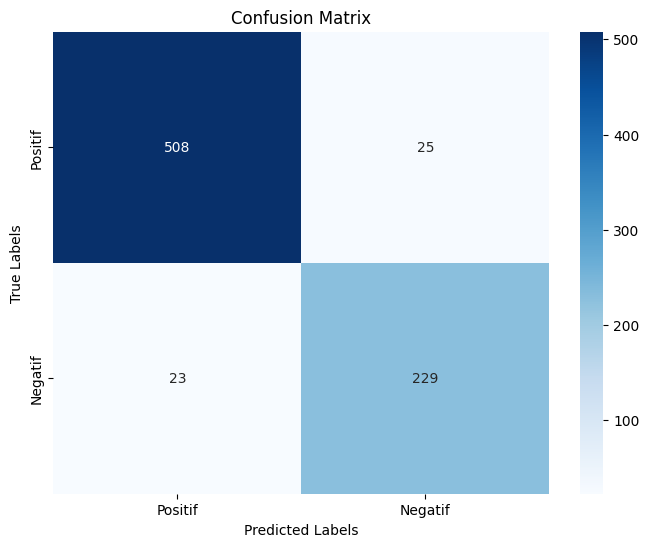

Accuracy: 0.94
Precision: 0.96
Recall: 0.95
F1 Score: 0.95


In [15]:
# Hitung metrik evaluasi pada data test
accuracy, precision, recall, f1, all_labels, all_predictions = evaluate_model(model, test_iterator, criterion)

# Tampilkan hasil metrik untuk sentimen positif
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

### **Kode Bersih**
Kode yang lebih bersih dan padat guna mengefisienkan ruang. Digunakan untuk kebutuhan skripsi.

Text Preprocessing

In [ ]:
# Kode per langkah preprocessing
# Step 1: Cleansing text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Step 2: Case folding
def case_folding(text):
    return text.lower()

# Step 3: Tokenisasi
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc] 

# Step 4: Menghapus stopword menggunakan daftar dari Sastrawi
stopword_factory = StopWordRemoverFactory()
stopword_list = set(stopword_factory.get_stop_words()) 

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopword_list]

# Step 5: Stemming menggunakan Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def stemming(tokens):
    return [stemmer.stem(word) for word in tokens]

In [ ]:
# Fungsi untuk menyimpan hasil setiap langkah ke CSV
def save_to_csv(df, step_name):
    filename = f'processed_data_{step_name}.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {step_name} result to {filename}")

# Fungsi utama untuk memproses dan menyimpan setiap langkah
def process_and_save_steps(df):
    # Step 1: Cleansing text
    df['cleaned_text'] = df['content'].apply(clean_text)
    save_to_csv(df[['content', 'cleaned_text']], 'cleansing')

    # Step 2: Case folding
    df['case_folding'] = df['cleaned_text'].apply(case_folding)
    save_to_csv(df[['cleaned_text', 'case_folding']], 'case_folding')

    # Step 3: Tokenisasi
    df['tokenized_text'] = df['case_folding'].apply(tokenize)
    save_to_csv(df[['case_folding', 'tokenized_text']], 'tokenization')

    # Step 4: Penghapusan stopword
    df['no_stopwords'] = df['tokenized_text'].apply(remove_stopwords)
    save_to_csv(df[['tokenized_text', 'no_stopwords']], 'stopword_removal')

    # Step 5: Stemming
    df['stemmed_text'] = df['no_stopwords'].apply(stemming)
    save_to_csv(df[['no_stopwords', 'stemmed_text']], 'stemming')

# Membaca file CSV sebagai DataFrame
df = pd.read_csv('review_content.csv')

# Menjalankan proses preprocessing
process_and_save_steps(df)